/home/pramananda/anaconda3/envs/annotation_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[+] Model: /home/pramananda/working_dir/qct-medical-image-auto-annotation/models/combined_model.pth
[+] Image: /home/pramananda/working_dir/qct-medical-image-auto-annotation/dataset/femur-bone/data/image/CT2/VH053_right_CT2.nii.gz
[+] Ground Truth: /home/pramananda/working_dir/qct-medical-image-auto-annotation/dataset/femur-bone/data/label/CT2/VH053_right_CT2.nii.gz
[+] Output: /home/pramananda/working_dir/qct-medical-image-auto-annotation/dataset/femur-bone/data/inference/CT2/VH053_right_CT2_pred.nii.gz
Using device: cpu
[+] Model loaded successfully
[+] Input image shape: torch.Size([1, 1, 206, 360, 212])
[+] Running inference...
[+] Saved prediction to /home/pramananda/working_dir/qct-medical-image-auto-annotation/dataset/femur-bone/data/inference/CT2/VH053_right_CT2_pred.nii.gz
[+] Loading ground truth for evaluation...
[!] Shape mismatch: pred (206, 360, 212) vs gt (256, 512, 212)
[+] Ground truth reshaped to: (206, 360, 212)
Calculating comprehensive metrics...

COMPREHENSIVE EVA

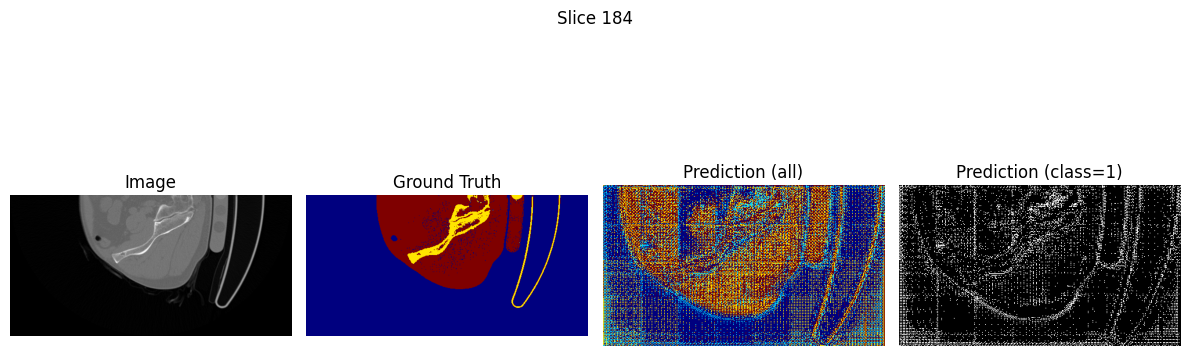

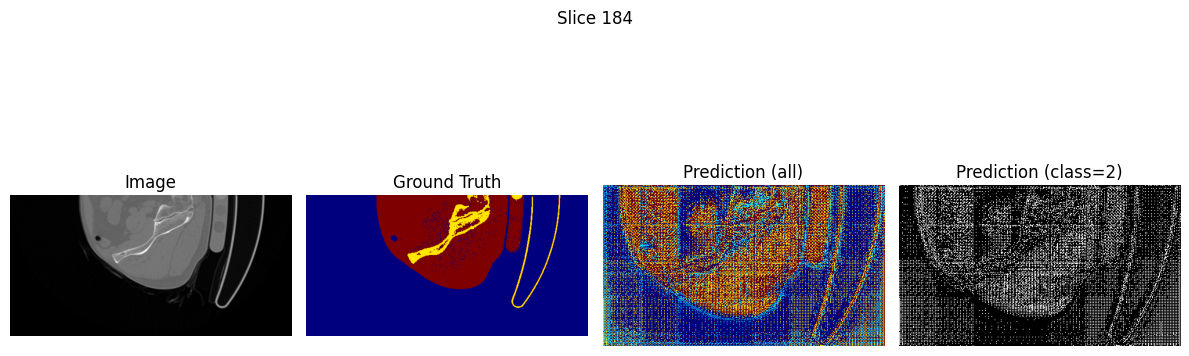

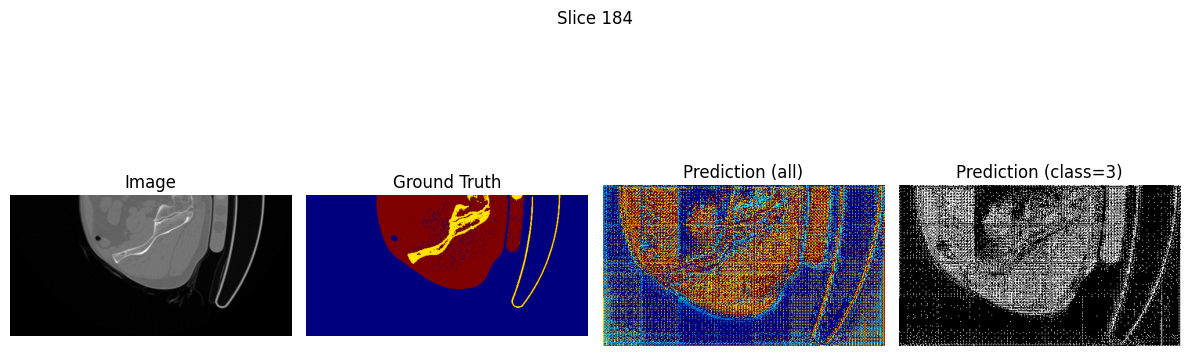

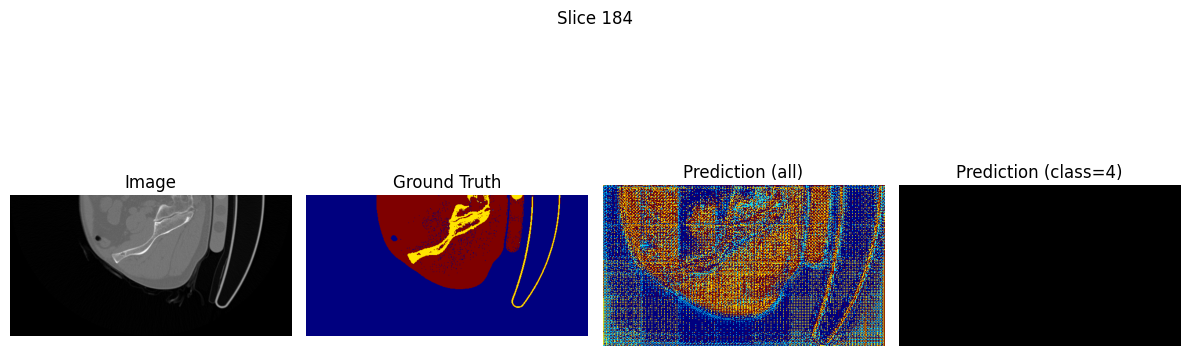

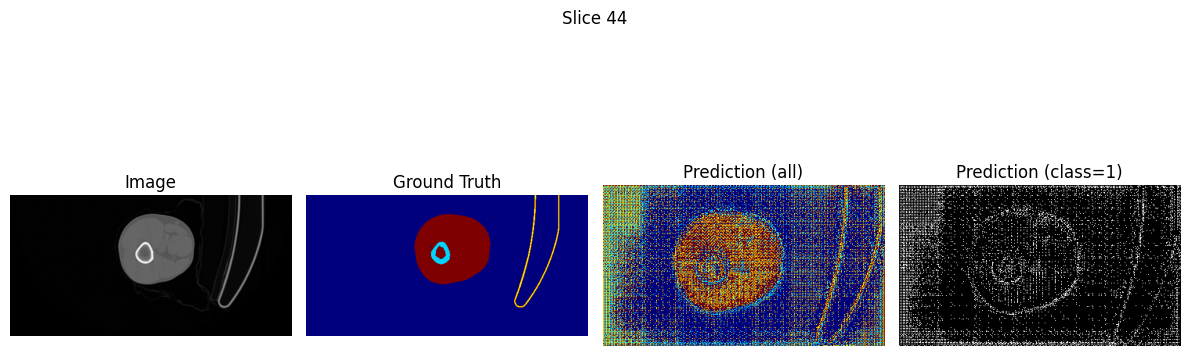

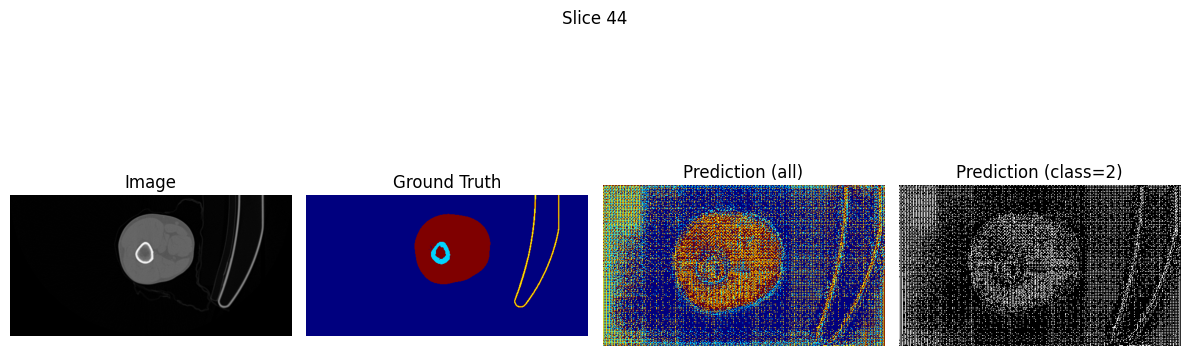

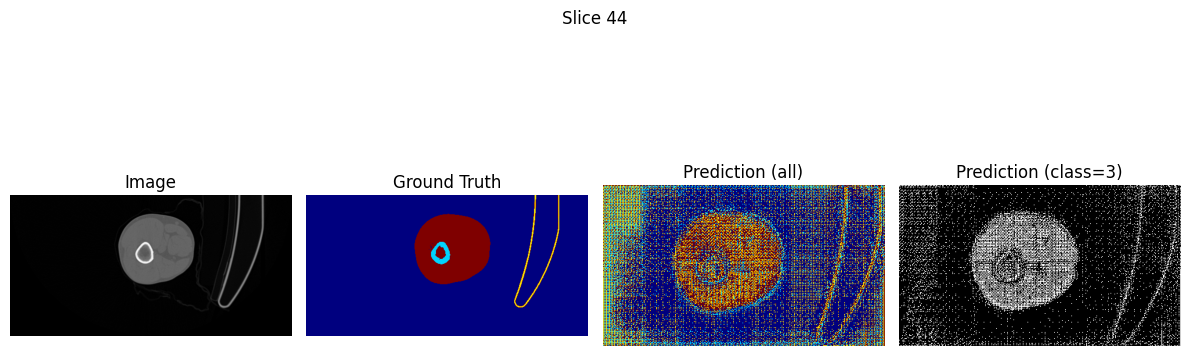

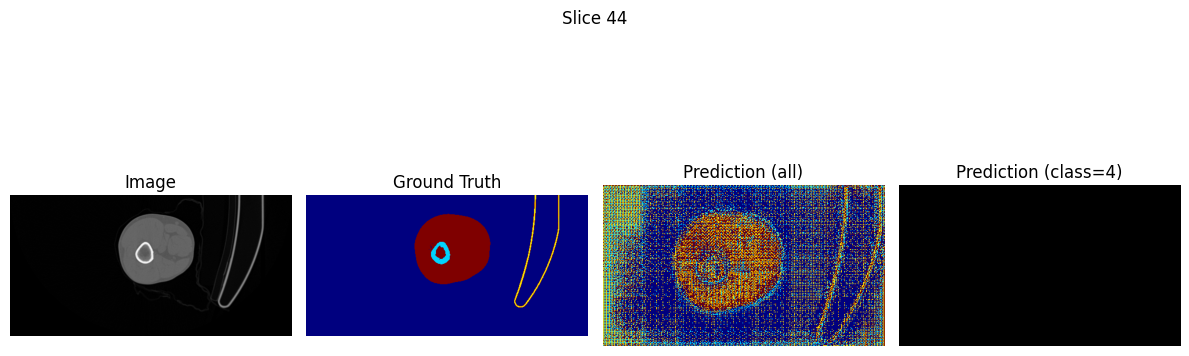

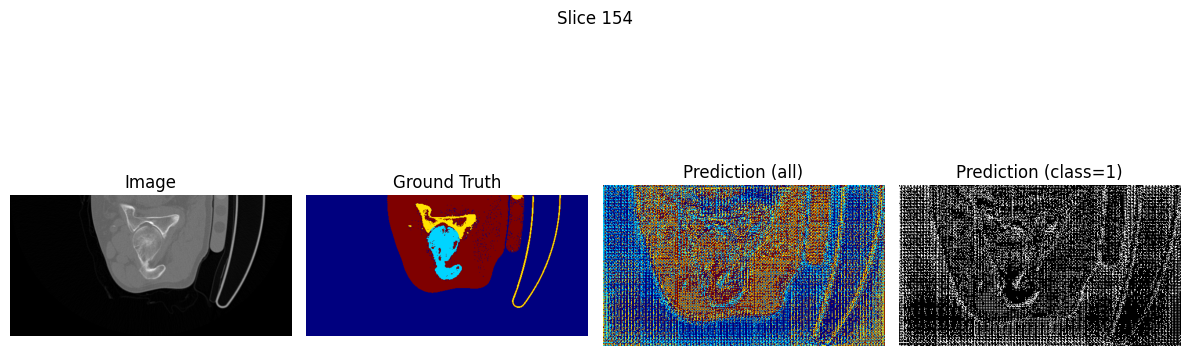

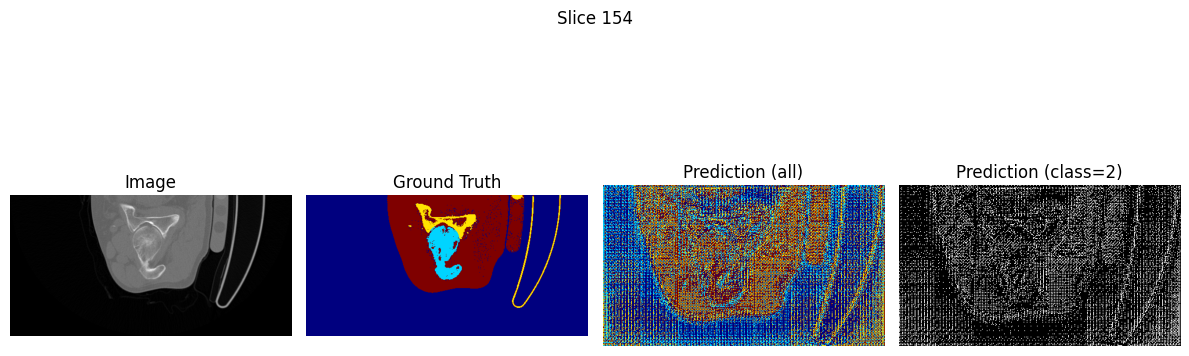

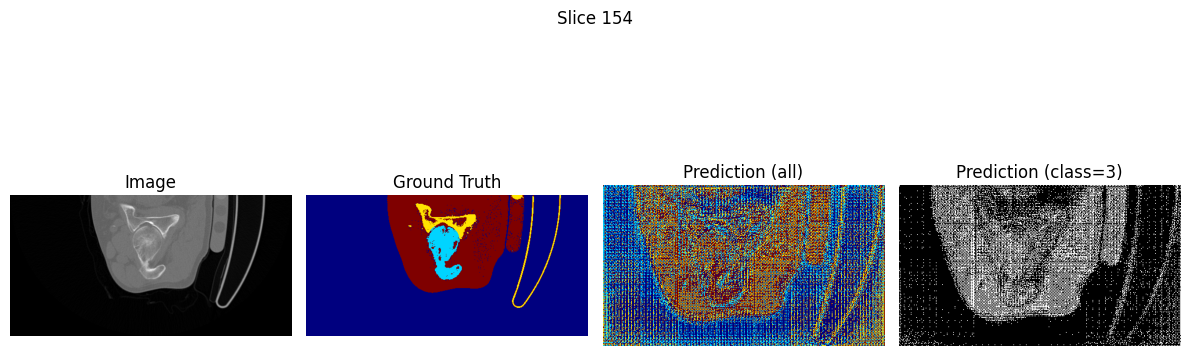

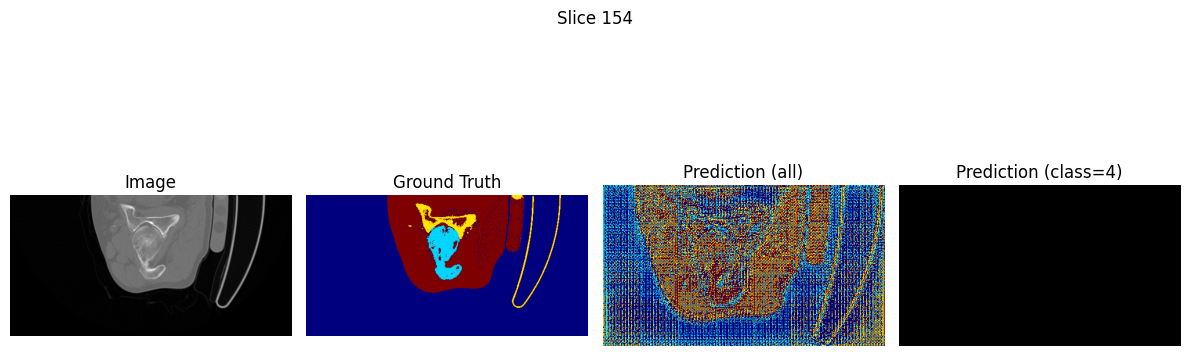

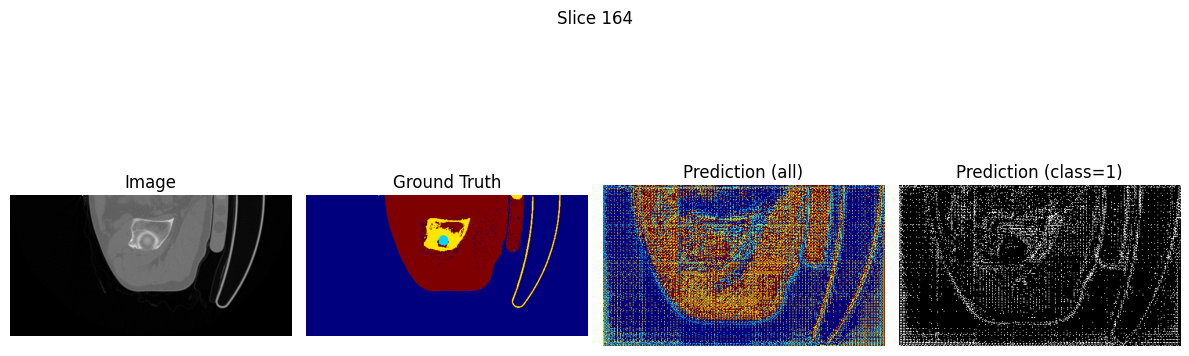

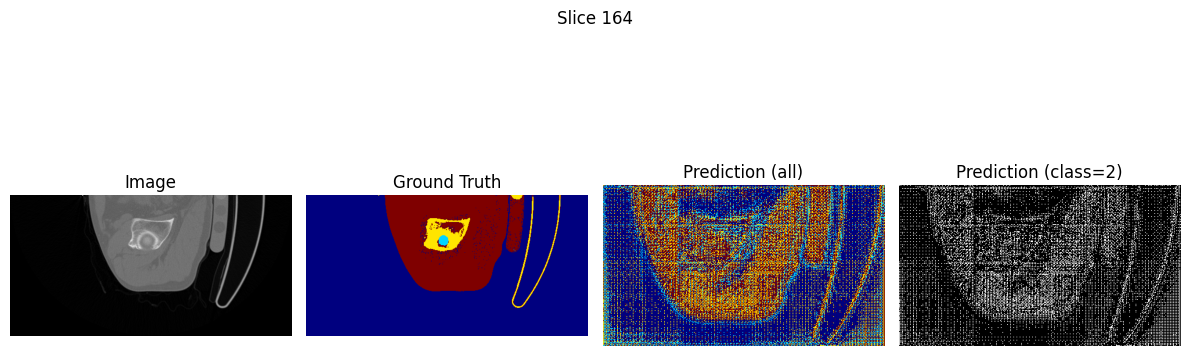

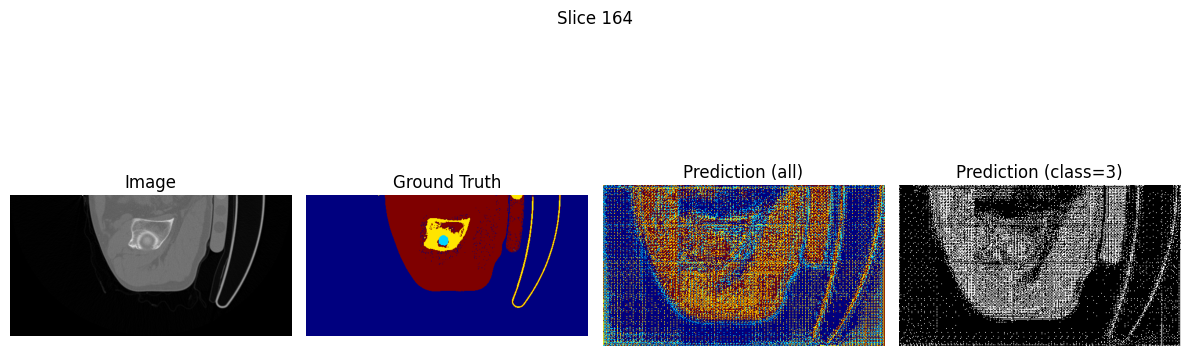

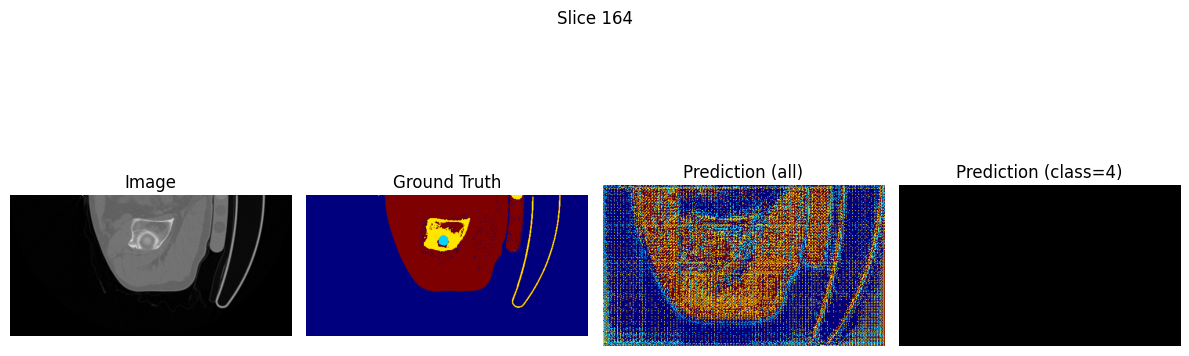

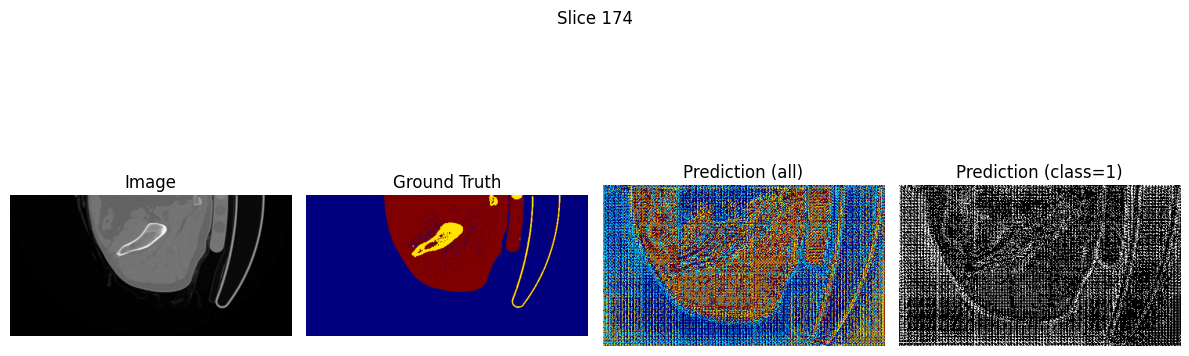

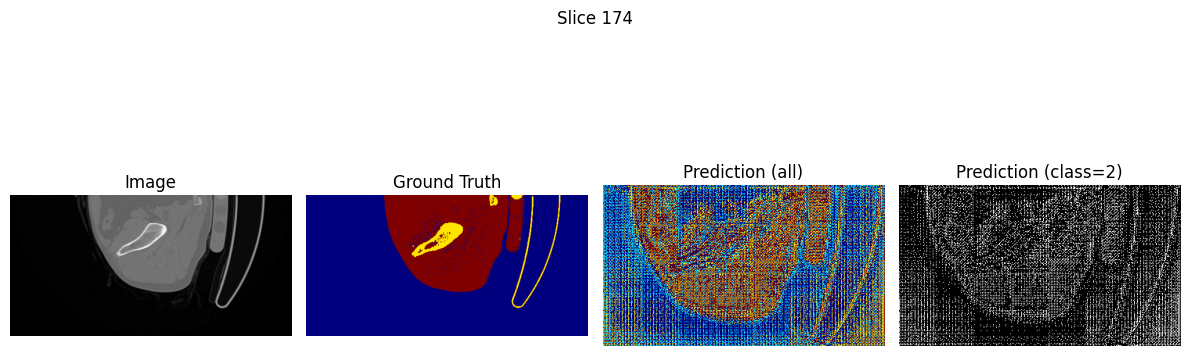

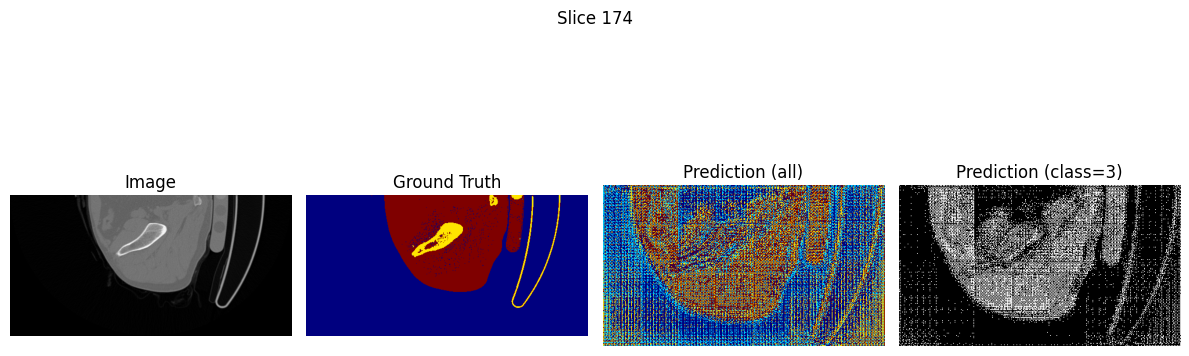

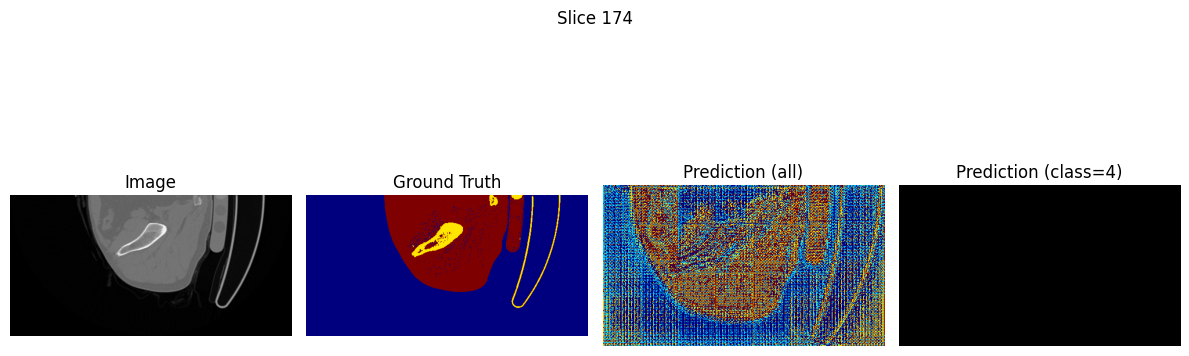


[+] Script completed successfully!


In [1]:
import os
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.metrics import confusion_matrix, classification_report
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd,
    ScaleIntensityRanged, CropForegroundd, EnsureTyped, ToTensord
)
from monai.data import Dataset
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.utils import set_determinism

# ==== Utility Functions ====
def match_label_to_image(image, label):
    """Match label dimensions to image dimensions"""
    for perm in [(0,1,2), (2,1,0), (0,2,1), (1,0,2), (1,2,0), (2,0,1)]:
        transposed = np.transpose(label, perm)
        if transposed.shape == image.shape:
            return transposed
    scale_factors = [i / l for i, l in zip(image.shape, label.shape)]
    resized_label = zoom(label, scale_factors, order=0)
    return resized_label

def show_side_by_side(image_slice, gt_slice, label_slice, title, target_class=1):
    """
    Show 4 panels:
      1. Image
      2. Ground Truth
      3. Prediction (all classes)
      4. Prediction (only target_class)
    """
    plt.figure(figsize=(12, 5))

    # Image
    plt.subplot(1, 4, 1)
    plt.imshow(image_slice, cmap='gray')
    plt.title("Image")
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 4, 2)
    plt.imshow(gt_slice, cmap='jet')
    plt.title("Ground Truth")
    plt.axis('off')

    # Prediction (all classes)
    plt.subplot(1, 4, 3)
    plt.imshow(label_slice, cmap='jet')
    plt.title("Prediction (all)")
    plt.axis('off')

    # Prediction (only target_class)
    single_class_mask = (label_slice == target_class).astype(np.uint8)
    plt.subplot(1, 4, 4)
    plt.imshow(single_class_mask, cmap='gray')
    plt.title(f"Prediction (class={target_class})")
    plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def load_image_gt_label(image_path, gt_path, label_path):
    """Load image, ground truth, and predicted label"""
    image = nib.load(image_path).get_fdata()
    gt = nib.load(gt_path).get_fdata()
    label = nib.load(label_path).get_fdata()
    return image, gt, label

def visualize(image_path, gt_path, label_path):
    """Visualize random slices"""
    image, gt, label = load_image_gt_label(image_path, gt_path, label_path)
    max_slices = image.shape[2]
    for _ in range(5):
        slice_idx = np.random.randint(0, max_slices)
        image_slice = image[:, :, slice_idx]
        gt_slice = gt[:, :, slice_idx]
        label_slice = label[:, :, slice_idx]
        title = f"Slice {slice_idx}"
        show_side_by_side(image_slice, gt_slice, label_slice, title, target_class=1)
        show_side_by_side(image_slice, gt_slice, label_slice, title, target_class=2)
        show_side_by_side(image_slice, gt_slice, label_slice, title, target_class=3)
        show_side_by_side(image_slice, gt_slice, label_slice, title, target_class=4)

def calculate_dice_score(y_true, y_pred, num_classes):
    """Calculate Dice score for each class"""
    dice_scores = {}
    for class_id in range(num_classes):
        y_true_class = (y_true == class_id).astype(np.float32)
        y_pred_class = (y_pred == class_id).astype(np.float32)
        
        intersection = np.sum(y_true_class * y_pred_class)
        union = np.sum(y_true_class) + np.sum(y_pred_class)
        
        if union == 0:
            dice = 1.0 if intersection == 0 else 0.0
        else:
            dice = (2.0 * intersection) / union
        
        dice_scores[f'class_{class_id}'] = dice
    
    return dice_scores

def calculate_iou(y_true, y_pred, num_classes):
    """Calculate IoU (Jaccard Index) for each class"""
    iou_scores = {}
    for class_id in range(num_classes):
        y_true_class = (y_true == class_id).astype(np.float32)
        y_pred_class = (y_pred == class_id).astype(np.float32)
        
        intersection = np.sum(y_true_class * y_pred_class)
        union = np.sum(y_true_class) + np.sum(y_pred_class) - intersection
        
        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0
        else:
            iou = intersection / union
        
        iou_scores[f'class_{class_id}'] = iou
    
    return iou_scores

def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    """Calculate sensitivity and specificity for each class"""
    metrics = {}
    
    for class_id in range(num_classes):
        y_true_class = (y_true == class_id).astype(np.int32)
        y_pred_class = (y_pred == class_id).astype(np.int32)
        
        tn = np.sum((y_true_class == 0) & (y_pred_class == 0))
        tp = np.sum((y_true_class == 1) & (y_pred_class == 1))
        fn = np.sum((y_true_class == 1) & (y_pred_class == 0))
        fp = np.sum((y_true_class == 0) & (y_pred_class == 1))
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        
        metrics[f'class_{class_id}_sensitivity'] = sensitivity
        metrics[f'class_{class_id}_specificity'] = specificity
        metrics[f'class_{class_id}_precision'] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        metrics[f'class_{class_id}_recall'] = sensitivity
        
    return metrics

def calculate_hausdorff_distance(y_true, y_pred, num_classes, spacing=(1.0, 1.0, 1.0)):
    """Calculate Hausdorff distance for each class"""
    from scipy.spatial.distance import directed_hausdorff
    from scipy.ndimage import binary_erosion
    
    hd_scores = {}
    
    for class_id in range(1, num_classes):  # Skip background class
        y_true_class = (y_true == class_id).astype(np.bool_)
        y_pred_class = (y_pred == class_id).astype(np.bool_)
        
        if not np.any(y_true_class) or not np.any(y_pred_class):
            hd_scores[f'class_{class_id}_hausdorff'] = np.inf
            continue
        
        # Get boundary points
        y_true_boundary = y_true_class ^ binary_erosion(y_true_class)
        y_pred_boundary = y_pred_class ^ binary_erosion(y_pred_class)
        
        if not np.any(y_true_boundary) or not np.any(y_pred_boundary):
            hd_scores[f'class_{class_id}_hausdorff'] = np.inf
            continue
        
        true_points = np.array(np.where(y_true_boundary)).T * np.array(spacing)
        pred_points = np.array(np.where(y_pred_boundary)).T * np.array(spacing)
        
        hd1 = directed_hausdorff(true_points, pred_points)[0]
        hd2 = directed_hausdorff(pred_points, true_points)[0]
        
        hd_scores[f'class_{class_id}_hausdorff'] = max(hd1, hd2)
    
    return hd_scores

def calculate_volume_metrics(y_true, y_pred, num_classes, spacing=(1.0, 1.0, 1.0)):
    """Calculate volume-based metrics"""
    volume_metrics = {}
    voxel_volume = np.prod(spacing)
    
    for class_id in range(num_classes):
        true_volume = np.sum(y_true == class_id) * voxel_volume
        pred_volume = np.sum(y_pred == class_id) * voxel_volume
        
        volume_diff = pred_volume - true_volume
        volume_ratio = pred_volume / true_volume if true_volume > 0 else np.inf
        
        volume_metrics[f'class_{class_id}_true_volume'] = true_volume
        volume_metrics[f'class_{class_id}_pred_volume'] = pred_volume
        volume_metrics[f'class_{class_id}_volume_diff'] = volume_diff
        volume_metrics[f'class_{class_id}_volume_ratio'] = volume_ratio
    
    return volume_metrics

def comprehensive_evaluation(y_true, y_pred, num_classes=4, spacing=(1.0, 1.0, 1.0)):
    """Calculate comprehensive metrics"""
    print("Calculating comprehensive metrics...")
    
    metrics = {}
    
    # Dice scores
    dice_scores = calculate_dice_score(y_true, y_pred, num_classes)
    metrics.update(dice_scores)
    
    # IoU scores
    iou_scores = calculate_iou(y_true, y_pred, num_classes)
    metrics.update(iou_scores)
    
    # Sensitivity, Specificity, Precision, Recall
    sens_spec = calculate_sensitivity_specificity(y_true, y_pred, num_classes)
    metrics.update(sens_spec)
    
    # Volume metrics
    volume_metrics = calculate_volume_metrics(y_true, y_pred, num_classes, spacing)
    metrics.update(volume_metrics)
    
    # Hausdorff distance (skip for large volumes to avoid memory issues)
    try:
        hd_metrics = calculate_hausdorff_distance(y_true, y_pred, num_classes, spacing)
        metrics.update(hd_metrics)
    except Exception as e:
        print(f"Warning: Could not calculate Hausdorff distance: {e}")
    
    # Overall accuracy
    accuracy = np.mean(y_true == y_pred)
    metrics['overall_accuracy'] = accuracy
    
    # Mean Dice (excluding background)
    mean_dice = np.mean([dice_scores[f'class_{i}'] for i in range(1, num_classes)])
    metrics['mean_dice'] = mean_dice
    
    # Mean IoU (excluding background)
    mean_iou = np.mean([iou_scores[f'class_{i}'] for i in range(1, num_classes)])
    metrics['mean_iou'] = mean_iou
    
    return metrics

def print_metrics(metrics):
    """Print metrics in a formatted way"""
    print("\n" + "="*50)
    print("COMPREHENSIVE EVALUATION METRICS")
    print("="*50)
    
    print(f"\nOverall Metrics:")
    print(f"  Overall Accuracy: {metrics.get('overall_accuracy', 0):.4f}")
    print(f"  Mean Dice Score:  {metrics.get('mean_dice', 0):.4f}")
    print(f"  Mean IoU Score:   {metrics.get('mean_iou', 0):.4f}")
    
    print(f"\nPer-Class Metrics:")
    num_classes = len([k for k in metrics.keys() if k.startswith('class_') and k.endswith('_volume')])
    
    for class_id in range(num_classes):
        print(f"\n  Class {class_id}:")
        print(f"    Dice Score:    {metrics.get(f'class_{class_id}', 0):.4f}")
        print(f"    IoU Score:     {metrics.get(f'class_{class_id}', 0):.4f}")
        print(f"    Sensitivity:   {metrics.get(f'class_{class_id}_sensitivity', 0):.4f}")
        print(f"    Specificity:   {metrics.get(f'class_{class_id}_specificity', 0):.4f}")
        print(f"    Precision:     {metrics.get(f'class_{class_id}_precision', 0):.4f}")
        print(f"    True Volume:   {metrics.get(f'class_{class_id}_true_volume', 0):.2f} mm³")
        print(f"    Pred Volume:   {metrics.get(f'class_{class_id}_pred_volume', 0):.2f} mm³")
        print(f"    Volume Ratio:  {metrics.get(f'class_{class_id}_volume_ratio', 0):.4f}")
        if f'class_{class_id}_hausdorff' in metrics:
            hd_val = metrics[f'class_{class_id}_hausdorff']
            if np.isinf(hd_val):
                print(f"    Hausdorff Dist: inf (no overlap)")
            else:
                print(f"    Hausdorff Dist: {hd_val:.2f} mm")

def save_metrics_to_file(metrics, output_path):
    """Save metrics to a text file"""
    metrics_file = output_path.replace('.nii.gz', '_metrics.txt')
    
    with open(metrics_file, 'w') as f:
        f.write("COMPREHENSIVE EVALUATION METRICS\n")
        f.write("="*50 + "\n")
        
        f.write(f"\nOverall Metrics:\n")
        f.write(f"  Overall Accuracy: {metrics.get('overall_accuracy', 0):.4f}\n")
        f.write(f"  Mean Dice Score:  {metrics.get('mean_dice', 0):.4f}\n")
        f.write(f"  Mean IoU Score:   {metrics.get('mean_iou', 0):.4f}\n")
        
        f.write(f"\nPer-Class Metrics:\n")
        num_classes = len([k for k in metrics.keys() if k.startswith('class_') and 'true_volume' in k])
        
        for class_id in range(num_classes):
            f.write(f"\n  Class {class_id}:\n")
            f.write(f"    Dice Score:    {metrics.get(f'class_{class_id}', 0):.4f}\n")
            f.write(f"    IoU Score:     {metrics.get(f'class_{class_id}', 0):.4f}\n")
            f.write(f"    Sensitivity:   {metrics.get(f'class_{class_id}_sensitivity', 0):.4f}\n")
            f.write(f"    Specificity:   {metrics.get(f'class_{class_id}_specificity', 0):.4f}\n")
            f.write(f"    Precision:     {metrics.get(f'class_{class_id}_precision', 0):.4f}\n")
            f.write(f"    True Volume:   {metrics.get(f'class_{class_id}_true_volume', 0):.2f} mm³\n")
            f.write(f"    Pred Volume:   {metrics.get(f'class_{class_id}_pred_volume', 0):.2f} mm³\n")
            f.write(f"    Volume Ratio:  {metrics.get(f'class_{class_id}_volume_ratio', 0):.4f}\n")
            if f'class_{class_id}_hausdorff' in metrics:
                hd_val = metrics[f'class_{class_id}_hausdorff']
                if np.isinf(hd_val):
                    f.write(f"    Hausdorff Dist: inf (no overlap)\n")
                else:
                    f.write(f"    Hausdorff Dist: {hd_val:.2f} mm\n")
    
    print(f"[+] Metrics saved to: {metrics_file}")

def run_inference_and_evaluation(model_path, image_path, label_path, output_path, num_classes=4):
    """Main function to run inference and calculate metrics"""
    
    # ==== Load Model ====
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=num_classes,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("[+] Model loaded successfully")

    # ==== Inference Transforms ====
    inference_transforms = Compose([
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear")),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=-500, a_max=1500, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image"]),
        ToTensord(keys=["image"]),
    ])

    # ==== Load Data ====
    data_dict = [{"image": image_path}]
    dataset = Dataset(data=data_dict, transform=inference_transforms)
    data = dataset[0]
    input_image = data["image"].unsqueeze(0).to(device)  # [B, C, H, W, D]
    print(f"[+] Input image shape: {input_image.shape}")

    # ==== Run Prediction ====
    print("[+] Running inference...")
    with torch.no_grad():
        pred_logits = sliding_window_inference(
            inputs=input_image,
            roi_size=(96, 96, 96),  # adjust to fit your GPU
            sw_batch_size=1,
            predictor=model,
            overlap=0.5
        )
        pred_labels = torch.argmax(pred_logits, dim=1).cpu().numpy()[0]

    # ==== Save Prediction ====
    # Get original affine from the image
    affine = nib.load(image_path).affine
    spacing = nib.load(image_path).header.get_zooms()
    
    nib.save(nib.Nifti1Image(pred_labels.astype(np.uint8), affine), output_path)
    print(f"[+] Saved prediction to {output_path}")

    # ==== Calculate Metrics ====
    if os.path.exists(label_path):
        print("[+] Loading ground truth for evaluation...")
        gt_data = nib.load(label_path).get_fdata()
        
        # Match dimensions if needed
        if pred_labels.shape != gt_data.shape:
            print(f"[!] Shape mismatch: pred {pred_labels.shape} vs gt {gt_data.shape}")
            gt_data = match_label_to_image(pred_labels, gt_data)
            print(f"[+] Ground truth reshaped to: {gt_data.shape}")
        
        # Calculate comprehensive metrics
        metrics = comprehensive_evaluation(
            gt_data.astype(np.int32), 
            pred_labels.astype(np.int32), 
            num_classes=num_classes,
            spacing=spacing
        )
        
        # Print metrics
        print_metrics(metrics)
        
        # Save metrics to file
        save_metrics_to_file(metrics, output_path)
        
        return metrics
    else:
        print(f"[!] Ground truth file not found: {label_path}")
        print("[+] Skipping evaluation")
        return None

if __name__ == "__main__":
    # Configuration
    model_path = "/home/pramananda/working_dir/qct-medical-image-auto-annotation/models/combined_model.pth"
    root_dir = "/home/pramananda/working_dir/qct-medical-image-auto-annotation/dataset/femur-bone/data"
    patient_id = "VH053_right"
    series_id = "CT2"
    
    # Paths
    image_path = os.path.join(root_dir, "image", series_id, f"{patient_id}_{series_id}.nii.gz")
    label_path = os.path.join(root_dir, "label", series_id, f"{patient_id}_{series_id}.nii.gz")
    
    output_dir = os.path.join(root_dir, "inference", series_id)
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{patient_id}_{series_id}_pred.nii.gz")
    
    # Verify input files exist
    if not os.path.exists(model_path):
        print(f"[!] Model file not found: {model_path}")
        exit(1)
    
    if not os.path.exists(image_path):
        print(f"[!] Image file not found: {image_path}")
        exit(1)
    
    print(f"[+] Model: {model_path}")
    print(f"[+] Image: {image_path}")
    print(f"[+] Ground Truth: {label_path}")
    print(f"[+] Output: {output_path}")
    
    # Run inference and evaluation
    metrics = run_inference_and_evaluation(
        model_path=model_path,
        image_path=image_path, 
        label_path=label_path,
        output_path=output_path,
        num_classes=4
    )
    
    # Optional: Visualize results if ground truth is available
    if metrics is not None and os.path.exists(label_path):
        print("\n[+] Creating visualizations...")
        try:
            visualize(image_path, label_path, output_path)
        except Exception as e:
            print(f"[!] Visualization failed: {e}")
    
    print("\n[+] Script completed successfully!")